# Training an autoencoder neural network with stochastic quantization model

Importing all required third-party dependencies

In [1]:
import os
import itertools
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, f1_score

import sq.optim as sq_optim
import sq.quantization as sq

Choosing a different algorithm for convolutions computations

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

To enforce reproducibility we set the random seed manually

In [3]:
RANDOM_SEED = 1909614334

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"Used random seed: {torch.initial_seed()}")

Used random seed: 1909614334


We set up the computation device for performing optimization

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"

We will use MNIST dataset of handwritten digits

In [5]:
EPOCHS = 25

BATCH_TRAIN = 512
BATCH_TEST = 512
DATA_DIR = '../../data/'
RESULTS_DIR = '../../results/'

train_dataset = datasets.MNIST(
    root=DATA_DIR, train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

test_dataset = datasets.MNIST(
    root=DATA_DIR, train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=True)

These are examples of handwritten digits from the dataset

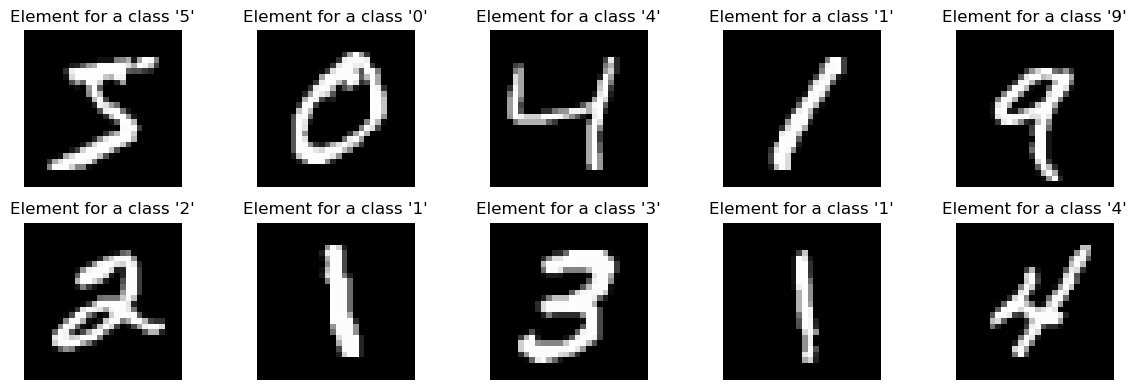

In [6]:
# Selecting random samples for the visual showcase
row_elements = 5

fig, axes = plt.subplots(2, row_elements, figsize=(12, 4))

# Display the samples in the image grid
for i, (image, label) in enumerate(
  itertools.islice(train_dataset, 2 * row_elements)
):
    row = i // row_elements
    col = i % row_elements

    axes[row, col].imshow(image.squeeze(), cmap="gray")
    axes[row, col].set_title(f"Element for a class '{label}'")
    axes[row, col].axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

A blueprint for a convolutional autoencoder neural network

In [7]:
class ConvAutoencoder(nn.Module):    
    def __init__(self, latent_dim=16):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Flatten(),

            nn.Linear(64 * 7 * 7, 64 * 7),
            nn.ReLU(),

            nn.Linear(64 * 7, 64),
            nn.ReLU(),

            nn.Linear(64, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),

            nn.Linear(64, 64 * 7),
            nn.ReLU(),

            nn.Linear(64 * 7, 64 * 7 * 7),
            nn.ReLU(),

            nn.Unflatten(1, (64, 7, 7)),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

Output dimensions of the decoder network should match the input tensor, to ensure the compatibility of input and output dimensions we will display these tensors on the grid. For untrained network, decoder output is a random noise.

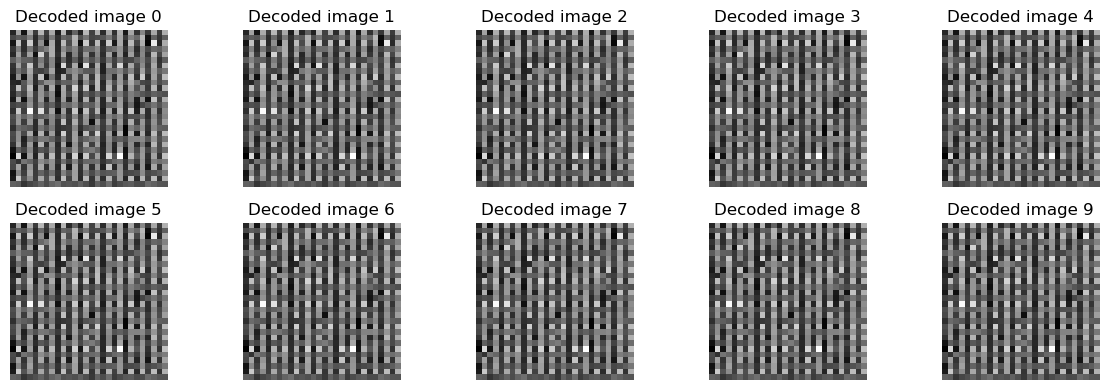

In [8]:
LATENT_DIM = 3

autoenc_model = ConvAutoencoder(latent_dim=LATENT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam([
    {'params': autoenc_model.encoder.parameters()},
    {'params': autoenc_model.decoder.parameters()}
], lr=0.001, weight_decay=1e-05)


images, labels = next(iter(test_dataloader))
fig, axes = plt.subplots(2, row_elements, figsize=(12, 4))


for i, image in enumerate(
  itertools.islice(autoenc_model(images.to(device)), 2 * row_elements)
):
    row = i // row_elements
    col = i % row_elements

    axes[row, col].imshow(image.cpu().detach().numpy().squeeze(), cmap="gray")
    axes[row, col].set_title(f"Decoded image {i}")
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

Training an instantiated Convolutional Autoencoder

In [9]:
train_loss, val_loss = [], []


for epoch in range(EPOCHS):
    epoch_train_loss = []
    epoch_val_loss = []

    # Training loss and accuracy
    autoenc_model.train()

    for images, _ in (progress_bar := tqdm(train_dataloader)):
        images = images.to(device)

        # Forward pass
        outputs = autoenc_model(images)
        loss = criterion(outputs, images)

        # Backpropagation
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        epoch_train_loss.append(loss.item())
        progress_bar.set_description(f"Train loss: {loss.item():.4f}")

    train_loss.append(np.mean(np.array(epoch_train_loss)))

    # Validation loss and accuracy
    autoenc_model.eval()

    with torch.no_grad():
        for images, _ in test_dataloader:
            images = images.to(device)

            outputs = autoenc_model(images)
            loss = criterion(outputs, images)

            epoch_val_loss.append(loss.item())

    val_loss.append(np.mean(np.array(epoch_val_loss)))

    print(f"Validation loss: {loss.item():.4f}")

Train loss: 0.0499: 100%|██████████| 118/118 [00:03<00:00, 30.34it/s]


Validation loss: 0.0485


Train loss: 0.0397: 100%|██████████| 118/118 [00:03<00:00, 32.19it/s]


Validation loss: 0.0381


Train loss: 0.0366: 100%|██████████| 118/118 [00:03<00:00, 31.48it/s]


Validation loss: 0.0364


Train loss: 0.0333: 100%|██████████| 118/118 [00:03<00:00, 31.91it/s]


Validation loss: 0.0345


Train loss: 0.0315: 100%|██████████| 118/118 [00:03<00:00, 33.07it/s]


Validation loss: 0.0334


Train loss: 0.0328: 100%|██████████| 118/118 [00:03<00:00, 31.96it/s]


Validation loss: 0.0333


Train loss: 0.0317: 100%|██████████| 118/118 [00:03<00:00, 31.78it/s]


Validation loss: 0.0326


Train loss: 0.0292: 100%|██████████| 118/118 [00:03<00:00, 30.93it/s]


Validation loss: 0.0336


Train loss: 0.0320: 100%|██████████| 118/118 [00:03<00:00, 32.47it/s]


Validation loss: 0.0319


Train loss: 0.0314: 100%|██████████| 118/118 [00:03<00:00, 31.37it/s]


Validation loss: 0.0299


Train loss: 0.0340: 100%|██████████| 118/118 [00:03<00:00, 32.38it/s]


Validation loss: 0.0325


Train loss: 0.0319: 100%|██████████| 118/118 [00:03<00:00, 32.57it/s]


Validation loss: 0.0338


Train loss: 0.0294: 100%|██████████| 118/118 [00:03<00:00, 32.16it/s]


Validation loss: 0.0301


Train loss: 0.0300: 100%|██████████| 118/118 [00:03<00:00, 32.40it/s]


Validation loss: 0.0330


Train loss: 0.0275: 100%|██████████| 118/118 [00:03<00:00, 32.14it/s]


Validation loss: 0.0300


Train loss: 0.0296: 100%|██████████| 118/118 [00:03<00:00, 32.32it/s]


Validation loss: 0.0327


Train loss: 0.0284: 100%|██████████| 118/118 [00:03<00:00, 32.01it/s]


Validation loss: 0.0295


Train loss: 0.0320: 100%|██████████| 118/118 [00:03<00:00, 32.93it/s]


Validation loss: 0.0302


Train loss: 0.0297: 100%|██████████| 118/118 [00:03<00:00, 32.33it/s]


Validation loss: 0.0318


Train loss: 0.0283: 100%|██████████| 118/118 [00:03<00:00, 32.69it/s]


Validation loss: 0.0297


Train loss: 0.0285: 100%|██████████| 118/118 [00:03<00:00, 32.22it/s]


Validation loss: 0.0283


Train loss: 0.0290: 100%|██████████| 118/118 [00:03<00:00, 32.80it/s]


Validation loss: 0.0303


Train loss: 0.0278: 100%|██████████| 118/118 [00:03<00:00, 31.75it/s]


Validation loss: 0.0299


Train loss: 0.0281: 100%|██████████| 118/118 [00:03<00:00, 32.61it/s]


Validation loss: 0.0298


Train loss: 0.0299: 100%|██████████| 118/118 [00:03<00:00, 31.70it/s]


Validation loss: 0.0293


We compare train and validation losses to detect the overfitting of the model

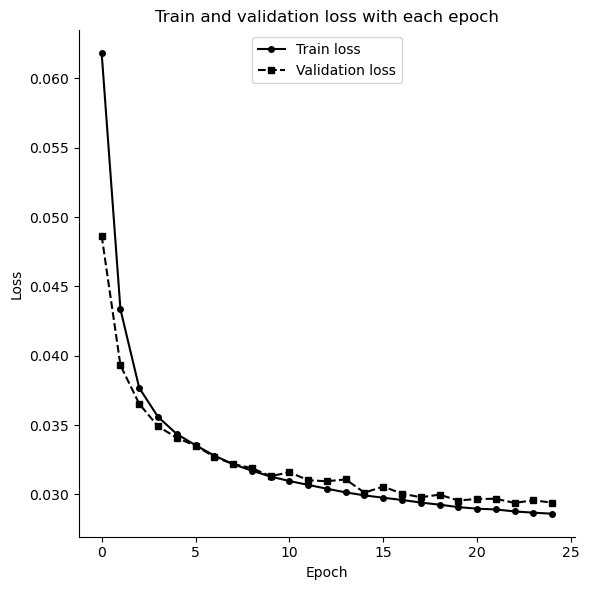

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

ax.plot(range(len(train_loss)), train_loss, linestyle='-',
           marker='o', color='k', markersize=4, label="Train loss")
ax.plot(range(len(val_loss)), val_loss, linestyle='--',
           marker='s', color='k', markersize=4, label="Validation loss")
ax.legend(loc="upper center")
ax.set_title("Train and validation loss with each epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

The decoder network outputs resemble an input data, which means encoder-decoder pair formed a bijective mapping from a discrete handwritten digit set, into a metric latent space

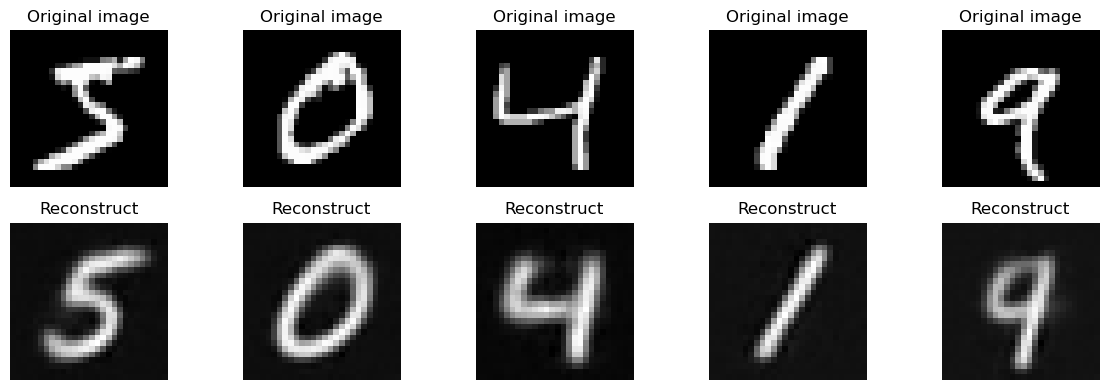

In [11]:
autoenc_model.eval()

row_elements = 5
fig, axes = plt.subplots(2, row_elements, figsize=(12, 4))

with torch.no_grad():
    for i, (image, label) in enumerate(
        itertools.islice(train_dataset, row_elements)
    ):
        axes[0, i].imshow(image.squeeze(), cmap="gray")
        axes[0, i].set_title(f"Original image")
        axes[0, i].axis("off")

        inp_image = image.reshape((1, 1, 28, 28)).to(device)

        reconst_image = autoenc_model(inp_image).reshape((1, 28, 28)).cpu()

        axes[1, i].imshow(reconst_image.squeeze(), cmap="gray")
        axes[1, i].set_title(f"Reconstruct")
        axes[1, i].axis("off")

plt.tight_layout()
plt.show()

We convert all handwritten digits from the dataset to visualize their embeddings in the metric space

In [12]:
def group_embeddings_by_label(model: nn.Module, dataloader: DataLoader):
    all_embeddings = np.empty((0, LATENT_DIM))
    grouped_embeddings = {i: np.empty((0, LATENT_DIM)) for i in range(10)}

    for img, lbs in dataloader:
        model_device = next(model.parameters()).device
        batch_embeddings = model(img.to(model_device))
        batch_embeddings = batch_embeddings.cpu().detach().numpy()

        lbs = lbs.detach().numpy()

        for emb, lb in zip(batch_embeddings, lbs):
            grouped_embeddings[lb] = np.vstack((grouped_embeddings[lb], np.array(emb)))

    for cl, embeds in grouped_embeddings.items():
        all_embeddings = np.vstack((all_embeddings, np.array(embeds)))

    return grouped_embeddings, all_embeddings


embedding_model = autoenc_model.encoder

with torch.no_grad():
    train_group_embeds, train_all_embeds = group_embeddings_by_label(embedding_model, train_dataloader)
    test_group_embeds, test_all_embeds = group_embeddings_by_label(embedding_model, test_dataloader)

If our latent space has a dimensionality greater than 3, we use PCA to project embeddings on a 3D plane, while trying to preserve an original distribution as much as possible with 90% of variance. As train data embeddings are positioned similarly to the test embeddings, we can assume that encoder learned low-level prepresentations

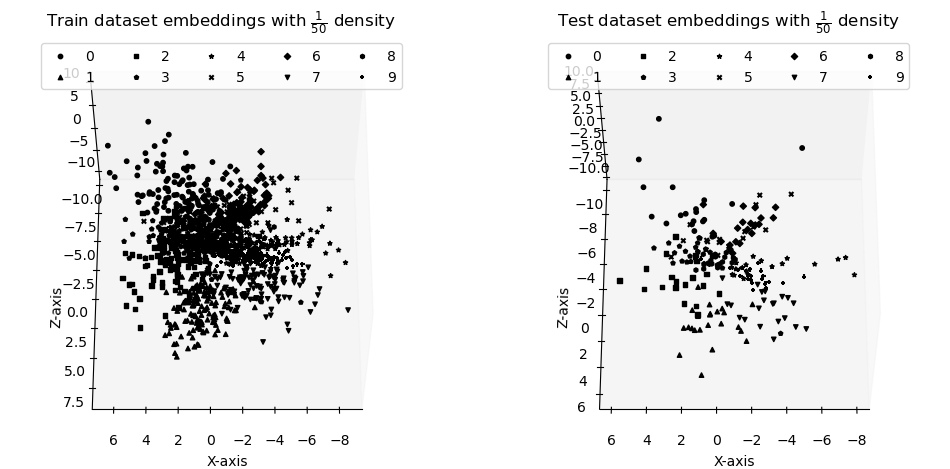

In [13]:
_, embeds_dim = train_all_embeds.shape

if embeds_dim > 3:
    pca = PCA(n_components=3, random_state=RANDOM_SEED).fit(train_all_embeds)

    train_viz_embeds = {cl: pca.transform(embeds) for cl, embeds in train_group_embeds.items()}
    test_viz_embeds = {cl: pca.transform(embeds) for cl, embeds in test_group_embeds.items()}
else:
    train_viz_embeds = train_group_embeds
    test_viz_embeds = test_group_embeds

markers = ['o', '^', 's', 'p', '*', 'x', 'D', 'v', 'h', '+']
markevery, marksize = 50, 10
elev, azim = 60, 90

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(elev=elev, azim=azim, roll=0)

for idx, (cls, embeds) in enumerate(train_viz_embeds.items()):
    subset_embeds = embeds[::markevery]
    ax.scatter3D(subset_embeds[:, 0], subset_embeds[:, 1], subset_embeds[:, 2], color='k',
                 label=cls, alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax.legend(loc="upper center", ncol=5)
ax.set_title(r'Train dataset embeddings with $ \frac{1}{50} $ density')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_ylabel('Z-axis')
ax.grid(False)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.view_init(elev=elev, azim=azim, roll=0)

for idx, (cls, embeds) in enumerate(test_viz_embeds.items()):
    subset_embeds = embeds[::markevery]
    ax.scatter3D(subset_embeds[:, 0], subset_embeds[:, 1], subset_embeds[:, 2], color='k',
                 label=cls, alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax.legend(loc="upper center", ncol=5)
ax.set_title(r'Test dataset embeddings with $ \frac{1}{50} $ density')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_ylabel('Z-axis')
ax.grid(False)

fig.patch.set_facecolor('white')

plt.show()

An autoencoder model is usually applied in the convex of unsupervised learning to create low level representations of unlabeled data, then an algorithm of unsupervised classification performs a grouping of these representations in some metric space. We will use stochastic quantization algorithm for the non-convex optimization problem of representations clustering

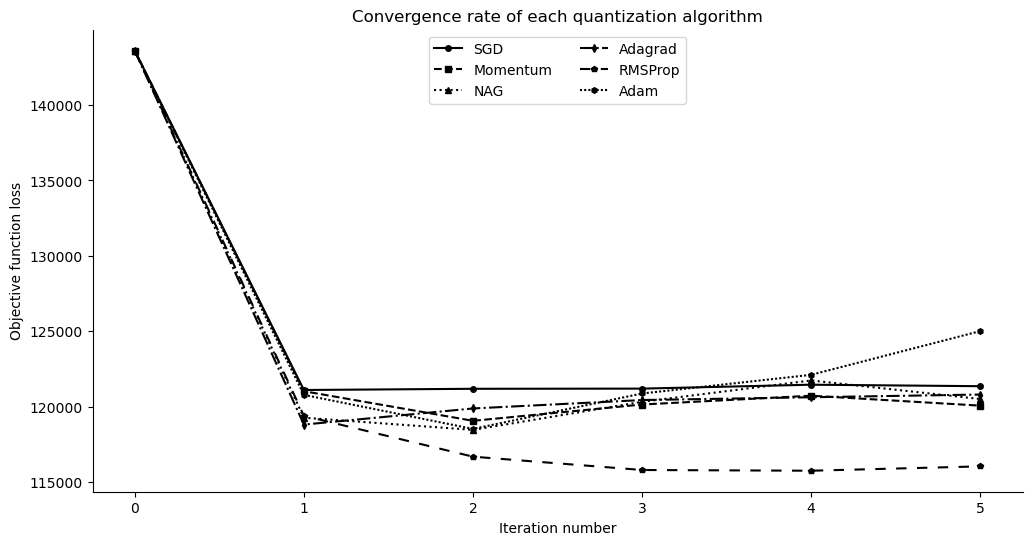

In [14]:
sq_algorithms = {
    "SGD": sq.StochasticQuantization(sq_optim.SGDOptimizer(), n_clusters=10, max_iter=5,
                                     random_state=np.random.RandomState(RANDOM_SEED)),
    "Momentum": sq.StochasticQuantization(sq_optim.MomentumOptimizer(), n_clusters=10, max_iter=5,
                                          learning_rate=0.0001, random_state=np.random.RandomState(RANDOM_SEED)),
    "NAG": sq.StochasticQuantization(sq_optim.NAGOptimizer(), n_clusters=10, max_iter=5,
                                     learning_rate=0.0001, random_state=np.random.RandomState(RANDOM_SEED)),
    "Adagrad": sq.StochasticQuantization(sq_optim.AdagradOptimizer(), n_clusters=10, max_iter=5,
                                         learning_rate=0.5, random_state=np.random.RandomState(RANDOM_SEED)),
    "RMSProp": sq.StochasticQuantization(sq_optim.RMSPropOptimizer(), n_clusters=10, max_iter=5,
                                         random_state=np.random.RandomState(RANDOM_SEED)),
    "Adam": sq.StochasticQuantization(sq_optim.AdamOptimizer(), n_clusters=10, max_iter=5,
                                      learning_rate=0.1, random_state=np.random.RandomState(RANDOM_SEED))
}

markers = [('o', '-'), ('s', '--'), ('^', ':'), ('d', '-.'), ('p', (0, (5, 5))), ('h', (0, (1, 1)))]
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    marker, linestyle = markers[idx % len(markers)]

    alg = alg.fit(train_all_embeds)

    ax.plot(range(len(alg.loss_history_)), alg.loss_history_,
            linestyle=linestyle, marker=marker, color='k',
            markersize=4, label=name)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Convergence rate of each quantization algorithm")
plt.xlabel('Iteration number')
plt.ylabel('Objective function loss')
plt.legend(loc="upper center", ncol=2)
plt.show()

We use confusion matrix to compare the accuracy of classification model for each class

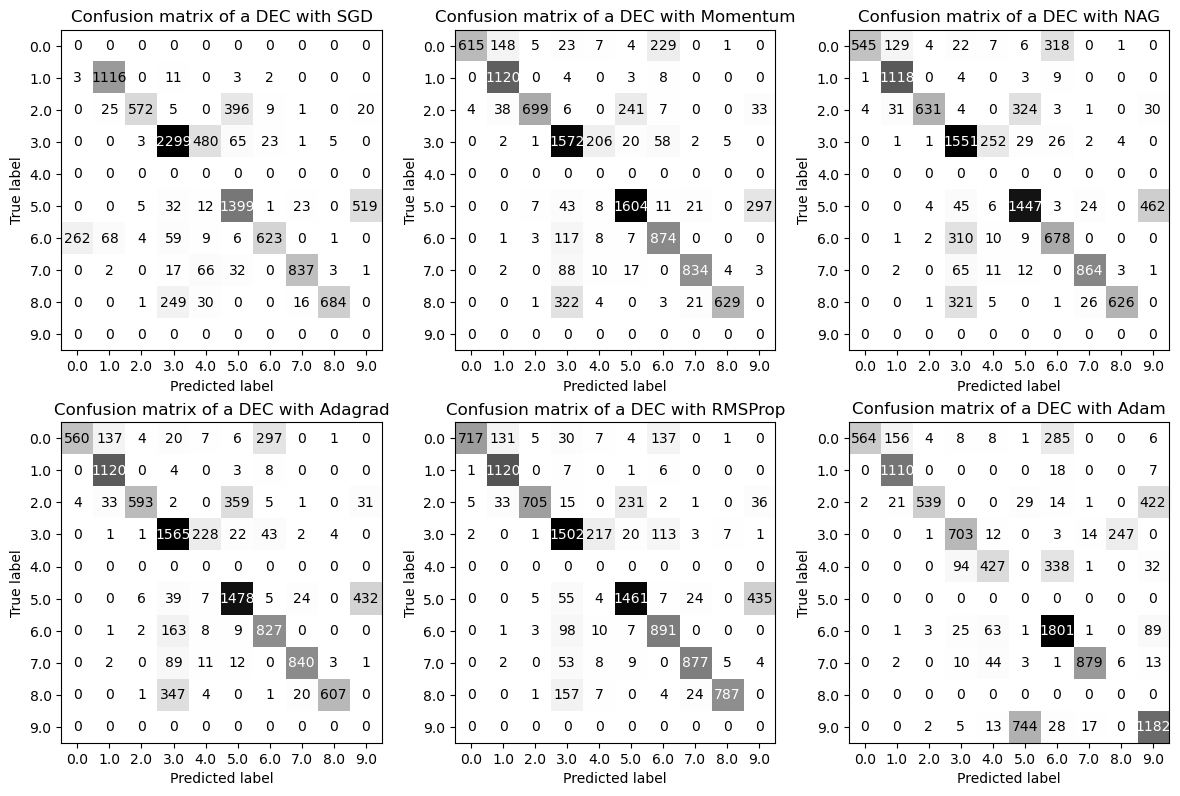

In [15]:
n_col, n_row = (2, 3)
fig, ax = plt.subplots(n_col, n_row, figsize=(12, 8))
f1_scores = {}

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    y_true, y_pred = np.array([]), np.array([])

    for _, embs in test_group_embeds.items():
        cls = alg.predict(embs)
        cls_predicted = np.bincount(cls).argmax()

        y_true = np.append(y_true, np.full((1, len(embs)), cls_predicted))
        y_pred = np.append(y_pred, cls)

    ax_idx = ax[idx // n_row, idx % n_row]

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, cmap="Greys", colorbar=False, ax=ax_idx
    )

    ax_idx.set_title(f"Confusion matrix of a DEC with {name}")
    f1_scores[name] = f1_score(y_true, y_pred, average="weighted")

plt.tight_layout()
plt.show()

To account for label imbalance in the test set, we choose a weighted F1 score as an accuracy metric.

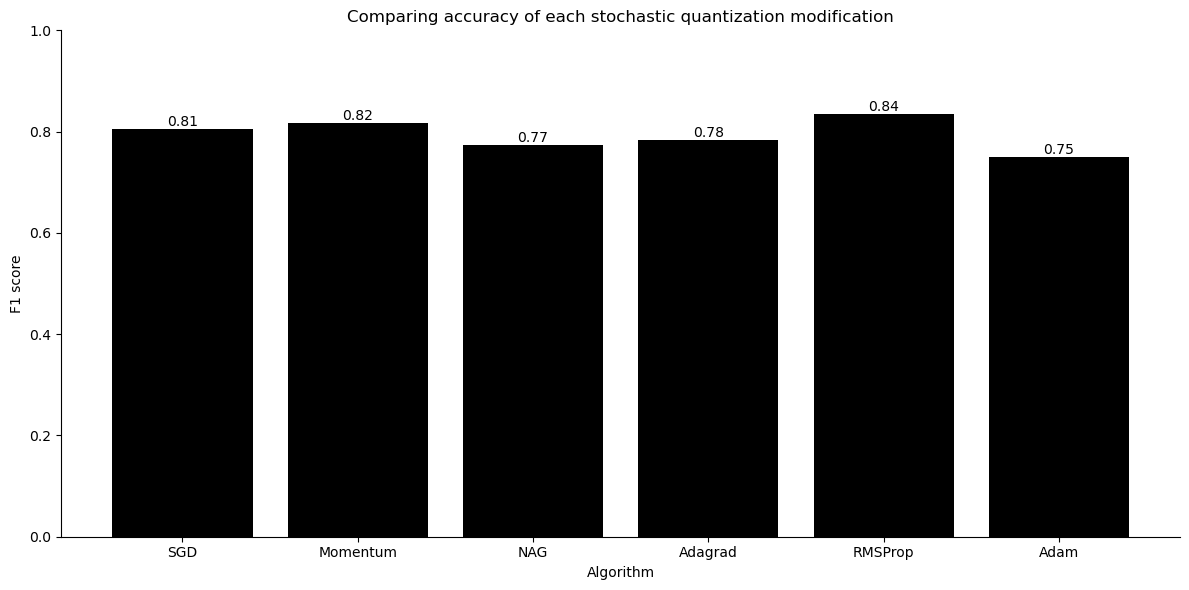

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

bars = ax.bar(f1_scores.keys(), f1_scores.values(), color='k')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0,
            height, f'{round(height, 2)}', ha='center', va='bottom')

ax.set_xlabel("Algorithm")
ax.set_ylabel("F1 score")
ax.set_title("Comparing accuracy of each stochastic quantization modification")
ax.set_ylim(top=1.0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Save encoder model for the later use

In [17]:
MODEL_DIR = os.path.join(RESULTS_DIR, "model")

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

embedding_model.eval()

torch.save(embedding_model.state_dict(), os.path.join(MODEL_DIR, "embedding_model.bin"))